In [ ]:
!pip install pyphen nltk wordfreq datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 76.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 24.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 require

# Complex Word Identification (CWI) for Lexical Simplification
Description: This script implements two approaches for Complex Word Identification: (1) A Feature-based Multi-Layer Perceptron (MLP) classifier using PyTorch, (2) A Soft Voting Ensemble combining Logistic Regression, Random Forest, and SVM.

Datasets:

CWI 2018 (News, WikiNews, Wikipedia splits)
MLSP 2024 LCP Trial split (for training)
MLSP 2024 LCP Test split (for evaluation)
Features Extracted:

Surface features (word length, syllables, vowel/consonant counts, capitalization, stopword status)
Lexical features (Zipf frequency, sentence length)
Semantic features (WordNet relations)
Psycholinguistic features (MRC Database: familiarity, AoA, concreteness, imagery)
Evaluation Metrics:

Accuracy
Macro F1-score
Confusion Matrix
Error Analysis (Top misclassified examples)
Objective: Identify whether a given target word in context is complex or simple to support downstream Lexical Simplification pipelines.

In [ ]:
!huggingface-cli login



    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) Y
Token is valid (permission: write).
The token `zaid1609` has been saved to /root/.cache/huggingface/stored_tokens
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when 

In [ ]:

import pandas as pd
import numpy as np
import pyphen
import nltk
from nltk.corpus import stopwords, wordnet
from wordfreq import zipf_frequency
from datasets import load_dataset

# NLTK data
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")

stop_words = set(stopwords.words("english"))
dic = pyphen.Pyphen(lang="en")

# Load CWI 2018 English
import pandas as pd

# GitHub base URL
base_url = "https://raw.githubusercontent.com/zaidkhan1609/Datasets/main/CWI%202018/"

#  List of file names
file_names = [
    "News_Train.tsv",
    "News_Dev.tsv",
    "WikiNews_Train.tsv",
    "WikiNews_Dev.tsv",
    "Wikipedia_Train.tsv",
    "Wikipedia_Dev.tsv"
]

#  Full URLs
file_urls = [base_url + file_name for file_name in file_names]

#  Load datasets directly from GitHub
cwi_dfs = [pd.read_csv(url, sep="\t", header=None) for url in file_urls]

#  Combine all splits
cwi_2018 = pd.concat(cwi_dfs, ignore_index=True)

#  Assign column names
cwi_2018.columns = [
    "id", "sentence", "start", "end", "target",
    "n_native", "n_non_native", "native_marked",
    "non_native_marked", "label", "prob_label"
]

# ✅ Select relevant columns and rename
cwi_2018 = cwi_2018[["sentence", "target", "label"]].rename(columns={"sentence": "context"})

# Load MLSP2024 train
mlsp_train = load_dataset("MLSP2024/MLSP2024", "english_lcp_labels", split="trial")
mlsp_df = pd.DataFrame(mlsp_train)
mlsp_df["label"] = mlsp_df["complexity"].apply(lambda x: 1 if x >= 0.25 else 0)
mlsp_df = mlsp_df[["context", "target", "label"]]

# Combine datasets
df = pd.concat([cwi_2018, mlsp_df], ignore_index=True).dropna()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


multils_test_english_lcp_labels.tsv:   0%|          | 0.00/101k [00:00<?, ?B/s]

multils_trial_english_lcp_labels.tsv:   0%|          | 0.00/4.36k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/570 [00:00<?, ? examples/s]

Generating trial split:   0%|          | 0/30 [00:00<?, ? examples/s]

In [ ]:

def get_syllables(word):
    return len(dic.inserted(word).split("-"))

def wordnet_features(word):
    syns = wordnet.synsets(word)
    return [
        len(syns),
        sum(len(s.hypernyms()) for s in syns),
        sum(len(s.hyponyms()) for s in syns),
        sum(len(s.part_meronyms()) for s in syns),
        sum(len(s.member_holonyms()) for s in syns)
    ]

def extract_features(row):
    word = row["target"]
    context = row["context"]
    features = [
        len(word),                                      # word length
        sum(c in "aeiouAEIOU" for c in word),           # vowel count
        sum(c.isalpha() and c.lower() not in "aeiou" for c in word),  # consonant count
        sum(not c.isalnum() for c in word),             # special characters
        get_syllables(word),
        word.istitle(),
        1 if word.lower() in stop_words else 0,
        zipf_frequency(word, "en"),
        len(context.split()),                           # sentence length
    ] + wordnet_features(word)
    return features

# Apply features
df["features"] = df.apply(extract_features, axis=1)
X = np.array(df["features"].tolist())
y = df["label"].values


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import train_test_split

# Convert feature arrays to tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Split into train/val
X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=0.1, random_state=42)

# Define the model
class FeatureMLP(nn.Module):
    def __init__(self, input_dim):
        super(FeatureMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)  # Binary classification
        )

    def forward(self, x):
        return self.model(x)

model = FeatureMLP(X.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 5
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    # Eval
    model.eval()
    with torch.no_grad():
        val_preds = torch.argmax(model(X_val), dim=1)
        acc = accuracy_score(y_val, val_preds)
        f1 = f1_score(y_val, val_preds, average='macro')
    print(f"Epoch {epoch+1}/{epochs} - Loss: {loss.item():.4f} - Acc: {acc:.4f} - Macro F1: {f1:.4f}")


Epoch 1/5 - Loss: 1.0305 - Acc: 0.4609 - Macro F1: 0.3903
Epoch 2/5 - Loss: 0.9338 - Acc: 0.4974 - Macro F1: 0.4091
Epoch 3/5 - Loss: 0.8523 - Acc: 0.5333 - Macro F1: 0.4375
Epoch 4/5 - Loss: 0.7792 - Acc: 0.5669 - Macro F1: 0.4694
Epoch 5/5 - Loss: 0.7325 - Acc: 0.6080 - Macro F1: 0.5137


In [ ]:
# -----------------------------
# Load and process MLSP 2024 test set
# -----------------------------
from datasets import load_dataset

# Load test set
mlsp_test = load_dataset("MLSP2024/MLSP2024", "english_lcp_labels", split="test")
mlsp_test_df = pd.DataFrame(mlsp_test)

# Create binary labels
mlsp_test_df["label"] = mlsp_test_df["complexity"].apply(lambda x: 1 if x >= 0.25 else 0)

# Drop NaNs if any
mlsp_test_df = mlsp_test_df.dropna(subset=["context", "target", "label"])

# Feature extraction (same as training)
mlsp_test_df["features"] = mlsp_test_df.apply(extract_features, axis=1)
X_test = torch.tensor(np.array(mlsp_test_df["features"].tolist()), dtype=torch.float32)
y_test = torch.tensor(mlsp_test_df["label"].values, dtype=torch.long)

# Evaluate on MLSP test
model.eval()
with torch.no_grad():
    test_preds = torch.argmax(model(X_test), dim=1)
    test_acc = accuracy_score(y_test, test_preds)
    test_f1 = f1_score(y_test, test_preds, average="macro")
    report = classification_report(y_test, test_preds)

print("✅ MLSP 2024 Test Accuracy:", test_acc)
print("✅ MLSP 2024 Test Macro F1:", test_f1)
print("📄 Detailed Report:\n", report)


✅ MLSP 2024 Test Accuracy: 0.656140350877193
✅ MLSP 2024 Test Macro F1: 0.5488175239079865
📄 Detailed Report:
               precision    recall  f1-score   support

           0       0.67      0.89      0.77       365
           1       0.55      0.23      0.33       205

    accuracy                           0.66       570
   macro avg       0.61      0.56      0.55       570
weighted avg       0.63      0.66      0.61       570



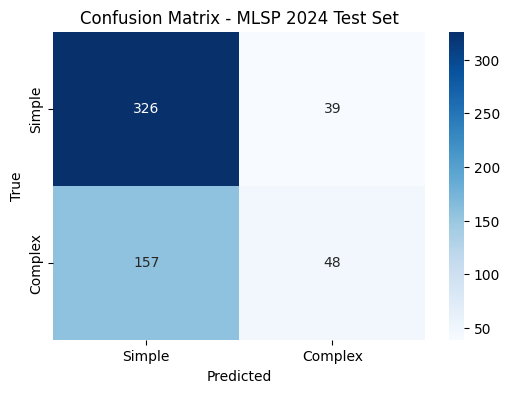


🔍 Top 10 Misclassified Words:
                                              context        target  true  \
0   After Ron nearly dies drinking poisoned mead t...    distraught     1   
2   After the war, Hitler remained in the army and...       oratory     1   
4   After the war, Hitler remained in the army and...  infiltrating     1   
8   Also, the frictional coefficient varies greatl...    frictional     1   
9   Also, the frictional coefficient varies greatl...    smoothness     1   
25  An ingenious alphabet allowed the Maya to reco...     ingenious     1   
31  As Governor, he followed such a strict policy ...        spoils     1   
32  As adjectives, their endings will vary accordi...     according     0   
35  As the single parabolic reflector achieves a g...     parabolic     1   
44  Attachment to the fibre is attributed, at leas...         fibre     1   

    predicted  
0           0  
2           0  
4           0  
8           0  
9           0  
25          0  
31       

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion Matrix
cm = confusion_matrix(y_test, test_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Simple", "Complex"], yticklabels=["Simple", "Complex"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - MLSP 2024 Test Set")
plt.show()

# Error Analysis: show misclassified examples
mlsp_test_df["predicted"] = test_preds.numpy()
mlsp_test_df["true"] = y_test.numpy()

# Filter misclassified rows
misclassified = mlsp_test_df[mlsp_test_df["predicted"] != mlsp_test_df["true"]]

# Show top 10 mistakes
print("\n🔍 Top 10 Misclassified Words:")
print(misclassified[["context", "target", "true", "predicted"]].head(10))


In [ ]:
# Load test set
mlsp_test = load_dataset("MLSP2024/MLSP2024", "english_lcp_labels", split="test")
test_df = pd.DataFrame(mlsp_test)
test_df["label"] = test_df["complexity"].apply(lambda x: 1 if x >= 0.25 else 0)

In [ ]:
import pandas as pd
import nltk
import pyphen
from nltk.corpus import stopwords, wordnet
from wordfreq import zipf_frequency
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from datasets import load_dataset

# ----------------------------
# Load NLTK resources
# ----------------------------
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")

stop_words = set(stopwords.words("english"))
dic = pyphen.Pyphen(lang="en")

# ----------------------------
# Load MRC psycholinguistic dataset
# ----------------------------
mrc_data = load_dataset("StephanAkkerman/MRC-psycholinguistic-database")["train"]
mrc_df = pd.DataFrame(mrc_data)
mrc_dict = mrc_df.set_index("Word").T.to_dict()

# ----------------------------
# Feature extraction
# ----------------------------
def extract_features(row):
    word = row["target"]
    features = {
        "word_len": len(word),
        "syllables": len(dic.inserted(word).split("-")),
        "is_stopword": int(word.lower() in stop_words),
        "syn_count": len(wordnet.synsets(word)),
        "zipf": zipf_frequency(word, "en", wordlist="best"),
    }

    mrc_features = mrc_dict.get(word.lower(), {})
    features["familiarity"] = mrc_features.get("familiarity", 0)
    features["aoa"] = mrc_features.get("aoa", 0)
    features["concreteness"] = mrc_features.get("concreteness", 0)
    features["imagery"] = mrc_features.get("imagery", 0)

    return pd.Series(features)

# ----------------------------
# Extract training features
# ----------------------------
X_train = df.apply(extract_features, axis=1)
y_train = df["label"]

# ----------------------------
# Extract test features (MLSP 2024 test set)
# ----------------------------
X_test = test_df.apply(extract_features, axis=1)
y_test = test_df["label"]

# ----------------------------
# Define soft voting ensemble
# ----------------------------
clf1 = LogisticRegression(max_iter=1000, random_state=42)
clf2 = RandomForestClassifier(n_estimators=100, random_state=42)
clf3 = SVC(kernel="linear", probability=True, random_state=42)

voting_model = Pipeline([
    ("scaler", StandardScaler()),
    ("ensemble", VotingClassifier(
        estimators=[("lr", clf1), ("rf", clf2), ("svm", clf3)],
        voting="soft"
    ))
])

# ----------------------------
# Train model
# ----------------------------
voting_model.fit(X_train, y_train)

# ----------------------------
# Predict and evaluate
# ----------------------------
y_pred = voting_model.predict(X_test)
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


README.md:   0%|          | 0.00/755 [00:00<?, ?B/s]

mrc_psycholinguistic_database.csv:   0%|          | 0.00/10.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/150000 [00:00<?, ? examples/s]

<ipython-input-11-a75323d8b1a0>:29: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  mrc_dict = mrc_df.set_index("Word").T.to_dict()


✅ Accuracy: 0.6649122807017543
              precision    recall  f1-score   support

           0       0.87      0.56      0.68       365
           1       0.52      0.84      0.64       205

    accuracy                           0.66       570
   macro avg       0.69      0.70      0.66       570
weighted avg       0.74      0.66      0.67       570



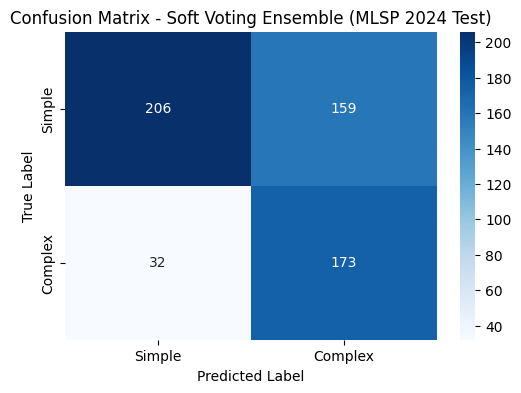


🔍 Top 10 Misclassified Words:
                                              context        target  true  \
11  Although it requires discipline, it is extreme...     backwards     0   
12  Although it requires discipline, it is extreme...    exhausting     0   
15  Although some frames are provided with three h...        frames     0   
21  Among these technologies was nuclear fission, ...  technologies     0   
24  An ingenious alphabet allowed the Maya to reco...     excellent     0   
30  As Governor, he followed such a strict policy ...    appointing     0   
36  As the single parabolic reflector achieves a g...      accuracy     0   
37  As the single parabolic reflector achieves a g...      focusing     0   
39  As well as being queen of the United Kingdom o...       monarch     0   
48  Because of the fact that his mating apparatus ...        ripped     1   

    predicted  
11          1  
12          1  
15          1  
21          1  
24          1  
30          1  
36       

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ----------------------------
# Confusion Matrix
# ----------------------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Simple", "Complex"], yticklabels=["Simple", "Complex"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Soft Voting Ensemble (MLSP 2024 Test)")
plt.show()

# ----------------------------
# Error Analysis
# ----------------------------
test_df["predicted"] = y_pred
test_df["true"] = y_test.values

# Misclassified samples
misclassified = test_df[test_df["predicted"] != test_df["true"]]

print("\n🔍 Top 10 Misclassified Words:")
print(misclassified[["context", "target", "true", "predicted"]].head(10))
